## Import Packages

In [1]:
import numpy as np
import pandas as pd
import pymatgen as pmg
import time
import matplotlib.pyplot as plt

from matminer.datasets.dataframe_loader import load_elastic_tensor
from matminer.utils.conversions import str_to_composition
from matminer.featurizers import composition as cf
from matminer.featurizers import structure as struc
from matminer.featurizers.base import MultipleFeaturizer

from pymatgen import MPRester

from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

### Loading pickle file

In [2]:
data = pd.read_pickle('./dejong_featurized_data.pkl')

### Part 1: Specifying input data

Here, we specify several different data sizes so that we can quantify performance of some machine learning algorithms with respect to the data input size. 

In [3]:
size = [10, 50, 100, 500, data.shape[0]]

variable_data = []
for i in range(len(size)):
    variable_data.append(shuffle(data)[:size[i]])

Elastic moduli value that we wish to predict. Choose from: "K_VRH" or "G_VRH"

In [4]:
learned_feature = 'G_VRH'

Input X and y 

In [5]:
original_columns = ['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
                    'K_VRH', 'poisson_ratio', 'structure', 'composition']

X = []
y = []
I = Imputer()
for i in range(len(variable_data)):
    x = variable_data[i].drop(original_columns, 1)
    X.append(I.fit_transform(x))
    y.append(np.log(variable_data[i][learned_feature]).as_matrix())

### Part 2: Choosing different ML models

We use several different ML algorithms to train the training set. Time performance and accuracy of the predictions of the respective models are printed. 

##### 5-fold cross-validation

In [6]:
num_splits = 5
kfold = KFold(num_splits, shuffle=False, random_state=0)

In [7]:
m = len(size)

#### 1) Generalized Linear Models: Linear Regression

In [8]:
mae_lr, rmse_lr, r2_lr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [9]:
time_lr = np.zeros((m,))

In [10]:
print ("Linear Regression: ")
start_lr = time.monotonic()
for i in range(m):
    start_lr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        lr = linear_model.LinearRegression()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        lr.fit(x_train, y_train)
        y_pred = lr.predict(x_test)

        mae_lr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_lr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_lr[i] += r2_score(y_test, y_pred) / num_splits

    finish_lr = time.monotonic()
    time_lr[i] = finish_lr - start_lr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_lr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_lr[i], rmse_lr[i], r2_lr[i]))
print ()

Linear Regression: 
-- Size of dataset: 10
Time: 0.012435 seconds
MAE = 0.844787, RMSE = 5.193454, R-SQUARED = -39.332311
-- Size of dataset: 50
Time: 0.007318 seconds
MAE = 2.037516, RMSE = 16.361909, R-SQUARED = -46.306536
-- Size of dataset: 100
Time: 0.023995 seconds
MAE = 2.279851, RMSE = 16.677863, R-SQUARED = -30.405814
-- Size of dataset: 500
Time: 0.026651 seconds
MAE = 0.281671, RMSE = 1.898235, R-SQUARED = 0.712728
-- Size of dataset: 1181
Time: 0.043990 seconds
MAE = 0.256078, RMSE = 1.778514, R-SQUARED = 0.768632



/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



#### 2) Generalized Linear Model:  Ridge Regression

In [11]:
mae_ridge, rmse_ridge, r2_ridge = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [12]:
time_ridge = np.zeros((m,))

In [13]:
print ("Ridge Regression: ")
for i in range(m):
    start_ridge = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        ridge = linear_model.RidgeCV()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        ridge.fit(x_train, y_train)
        y_pred = ridge.predict(x_test)

        mae_ridge[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_ridge[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_ridge[i] += r2_score(y_test, y_pred) / num_splits
    finish_ridge = time.monotonic()
    time_ridge[i] = finish_ridge - start_ridge
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_ridge[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_ridge[i], rmse_ridge[i], r2_ridge[i]))
print ()

Ridge Regression: 
-- Size of dataset: 10
Time: 0.007930 seconds
MAE = 0.846534, RMSE = 5.197289, R-SQUARED = -39.348599
-- Size of dataset: 50
Time: 0.012674 seconds
MAE = 0.646391, RMSE = 5.210795, R-SQUARED = -5.474645
-- Size of dataset: 100
Time: 0.017061 seconds
MAE = 0.385423, RMSE = 2.554968, R-SQUARED = 0.429844
-- Size of dataset: 500
Time: 0.035495 seconds
MAE = 0.275233, RMSE = 1.871095, R-SQUARED = 0.717125
-- Size of dataset: 1181
Time: 0.104286 seconds
MAE = 0.260284, RMSE = 1.803363, R-SQUARED = 0.761866



Plot performances of both linear models

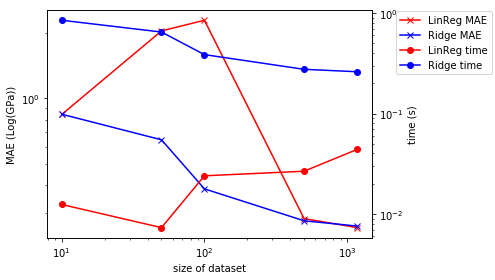

In [14]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_lr, color='r', marker='x', label='LinReg MAE')
ax1.loglog(size, mae_ridge, color='b', marker='x', label='Ridge MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_lr, color='r', marker='o', label='LinReg time')
ax2.loglog(size, mae_ridge, color='b', marker='o', label='Ridge time')

fig.legend(bbox_to_anchor=(1.15, 0.95))
fig.tight_layout()
plt.show()

#### 3) Ensemble method: RandomForestRegressor 

100 estimators are used

In [15]:
num_trees = 100

In [16]:
mae_rfr, rmse_rfr, r2_rfr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [17]:
time_rfr = np.zeros((m,))

In [18]:
print ("Random Forest Regression: ")
for i in range(m):
    start_rfr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        rfr = RandomForestRegressor(n_estimators=num_trees)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)

        mae_rfr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_rfr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_rfr[i] += r2_score(y_test, y_pred) / num_splits
    finish_rfr = time.monotonic()
    time_rfr[i] = finish_rfr - start_rfr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_rfr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_rfr[i], rmse_rfr[i], r2_rfr[i]))
print ()

Random Forest Regression: 
-- Size of dataset: 10
Time: 0.512166 seconds
MAE = 0.788722, RMSE = 4.523145, R-SQUARED = -29.948375
-- Size of dataset: 50
Time: 0.987957 seconds
MAE = 0.393048, RMSE = 2.602046, R-SQUARED = 0.420264
-- Size of dataset: 100
Time: 1.460645 seconds
MAE = 0.383602, RMSE = 2.513070, R-SQUARED = 0.436009
-- Size of dataset: 500
Time: 7.025876 seconds
MAE = 0.284591, RMSE = 2.007316, R-SQUARED = 0.681474
-- Size of dataset: 1181
Time: 18.901208 seconds
MAE = 0.253792, RMSE = 1.781615, R-SQUARED = 0.767670



Plot performance

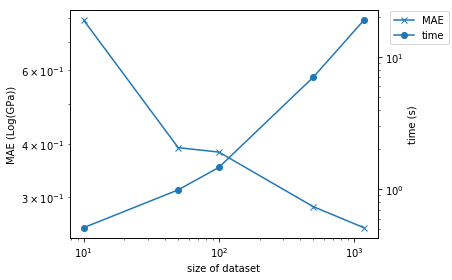

In [19]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_rfr, marker='x', label='MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_rfr, marker='o', label='time')

fig.legend(bbox_to_anchor=(1.05, 0.95))
fig.tight_layout()
plt.show()

#### 4) Ensemble method: ExtraTreesRegressor

In [20]:
mae_efr, rmse_efr, r2_efr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [21]:
time_efr = np.zeros((m,))

In [22]:
print ("Extra Trees Regression: ")
for i in range(m):
    start_efr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        efr = ExtraTreesRegressor(n_estimators=num_trees)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        efr.fit(x_train, y_train)
        y_pred = efr.predict(x_test)

        mae_efr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_efr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_efr[i] += r2_score(y_test, y_pred) / num_splits
    finish_efr = time.monotonic()
    time_efr[i] = finish_efr - start_efr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_efr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_efr[i], rmse_efr[i], r2_efr[i]))
print ()

Extra Trees Regression: 
-- Size of dataset: 10
Time: 0.469759 seconds
MAE = 0.946681, RMSE = 5.359231, R-SQUARED = -89.919663
-- Size of dataset: 50
Time: 0.668647 seconds
MAE = 0.389348, RMSE = 2.558224, R-SQUARED = 0.482564
-- Size of dataset: 100
Time: 1.231120 seconds
MAE = 0.368242, RMSE = 2.413669, R-SQUARED = 0.478983
-- Size of dataset: 500
Time: 3.799111 seconds
MAE = 0.283404, RMSE = 1.964071, R-SQUARED = 0.694347
-- Size of dataset: 1181
Time: 8.055592 seconds
MAE = 0.241239, RMSE = 1.715115, R-SQUARED = 0.784142



Plot performance

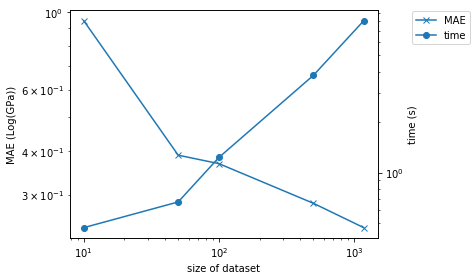

In [23]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_efr, marker='x', label='MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_efr, marker='o', label='time')

fig.legend(bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()
plt.show()

#### 5) Ensemble method: GradientBoosting 

In [24]:
mae_gradient, rmse_gradient, r2_gradient = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [25]:
time_gradient = np.zeros((m,))

In [26]:
print ("Gradient Boosting Regression: ")
for i in range(m):
    start_gradient = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        gradient = GradientBoostingRegressor(n_estimators=250, max_depth=3)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        gradient.fit(x_train, y_train)
        y_pred = gradient.predict(x_test)

        mae_gradient[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_gradient[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_gradient[i] += r2_score(y_test, y_pred) / num_splits
    finish_gradient = time.monotonic()
    time_gradient[i] = finish_gradient - start_gradient
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_gradient[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_gradient[i], rmse_gradient[i], r2_gradient[i]))
print ()

Gradient Boosting Regression: 
-- Size of dataset: 10
Time: 0.189977 seconds
MAE = 1.030005, RMSE = 6.088558, R-SQUARED = -68.891513
-- Size of dataset: 50
Time: 0.403006 seconds
MAE = 0.422721, RMSE = 2.889287, R-SQUARED = 0.253393
-- Size of dataset: 100
Time: 0.921799 seconds
MAE = 0.375572, RMSE = 2.405448, R-SQUARED = 0.484226
-- Size of dataset: 500
Time: 3.966323 seconds
MAE = 0.270792, RMSE = 1.907835, R-SQUARED = 0.708514
-- Size of dataset: 1181
Time: 10.647397 seconds
MAE = 0.242658, RMSE = 1.703439, R-SQUARED = 0.787283



Plot performance

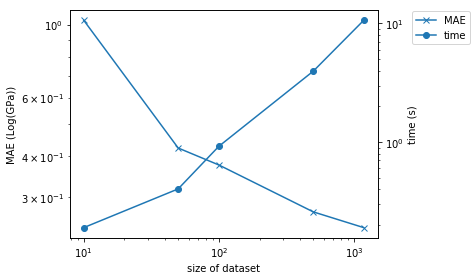

In [27]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_gradient, marker='x', label='MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_gradient, marker='o', label='time')

fig.legend(bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()
plt.show()

#### Quantifying trade off of time performance and accuracy of model with respect to size of data 

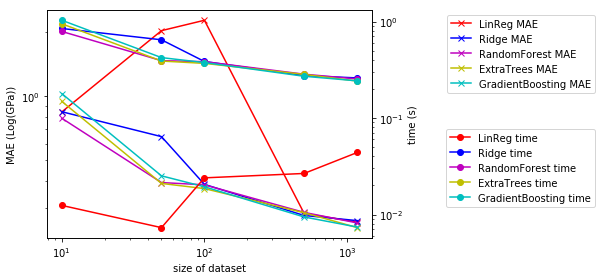

In [28]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_lr, color='r', marker='x', label='LinReg MAE')
ax1.loglog(size, mae_ridge, color='b', marker='x', label='Ridge MAE')
ax1.loglog(size, mae_rfr, color='m', marker='x', label='RandomForest MAE')
ax1.loglog(size, mae_efr, color='y', marker='x', label='ExtraTrees MAE')
ax1.loglog(size, mae_gradient, color='c', marker='x', label='GradientBoosting MAE')
ax1.legend(bbox_to_anchor=(1.7, 1))

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_lr, color='r', marker='o', label='LinReg time')
ax2.loglog(size, mae_ridge, color='b', marker='o', label='Ridge time')
ax2.loglog(size, mae_rfr, color='m', marker='o', label='RandomForest time')
ax2.loglog(size, mae_efr, color='y', marker='o', label='ExtraTrees time')
ax2.loglog(size, mae_gradient, color='c', marker='o', label='GradientBoosting time')
ax2.legend(bbox_to_anchor=(1.7, 0.5))

fig.tight_layout()
plt.show()